# Lab 1: Step Test of a First-Order System

--- BEGIN HIDDEN NOTE

© Alexander Dowling, Jeremiah Zartman et al, University of Notre Dame (2026).
Updated copyright 2026

These solutions are for private use by enrolled students. You may not distribute these assignment solutions without written permission from the CBE 30338 instructor. Students enrolled in CBE 30338 may not use solutions for prior years while preparing their assignment submissions.

--- END HIDDEN NOTE

*Your Name:* 

This notebook outlines a process for fitting a first-order model of a heater/sensor assembly to data taken during a step test. The learning goals for this notebook are:

* Read and plot a previously saved step test data using the `Pandas` library.
* By inspection, identify the gain and dominant time constant of the step test.
* Simulate the response of a first-order model to step test.
* Through iteration, adjust model parameters to fit the first order model to step test data. 
* Understand the relationship of model parameters to gain and time constant.
* Determine if a first-order model provides an adequate description of the observed response.

Our labratory assignments this semester build up each other. For best results, you want to **use the same hardware configuration for each lab**. To help with this, please fill in the following:
* **TCLab**: Did you use your own TCLab or borrow one (friend, class set)?
* **Power adapter**: How did you plug the TCLab into power? Did you use the adapter that came with your kit, a different USB power adapter, or one of the plugs in our computer classroom? What is the power rating of the adapter? (e.g., 1A or 2A or 2.1A at 5V?, Was the power adapter/USB port labeled "phone" or "tablet"?)
* Suggestion: take a picture of your TCLab setup including the power adapter. Keep this on your phone until the end of the semester.

## Exercise 0. Analyze a Previous Dataset

### First-order lumped model for heater/sensor device.

We have previously developed a first-order model for one heater/sensor pair on the temperature control lab device.  An energy balance gives

\begin{equation*}
C_p\frac{dT_1}{dt} = U_a(T_{amb} - T_1) + \alpha P_1u_1
\end{equation*}

where $T_1$ is the average temperature of heater/sensor one, $T_{amb}$ is the ambient temperature of the surroundings. The unknown parameters are the heat capacity $C_p$ and the heat transfer coefficient $U_a$.

The parameters describing the heat input are as follows:

* $\alpha$ is a system calibration constant  The measured value of $\alpha$ is 0.16 milliwatts per unit of $P_1$ per percent.
* $P_1$ is a constant integer value in the range 0 to 255 that controls the operating range of heater 1. It is set using the `tclab` library.
* $u_1$ is a floating point value in the range 0 to 100 that specify the percentage of available power for heater 1.

For example, if $P_1 = 255$ and $u_1 = 100$, then the total applied power is

\begin{equation*}
\alpha_1 P_1 u_1 = 0.16 \times 200 \times 50 = 4080\ \text{milliwatts} = 4.08\ \text{watts}
\end{equation*}





### Reading previously saved experimental data

A step test was performed where the temperature control laboratory was initially at steady state at ambient temperature. The heater range $P_1$ was set to 200, then  heater 1 was set to 50% of full range with $\bar{u}_1 = 50$. Temperatures $T_1$ and $T_2$ were recorded for 800 seconds. The has been saved to the course Github repository where it can be located with the url

[https://raw.githubusercontent.com/ndcbe/controls/main/tclab/data/tclab-data.csv]("https://raw.githubusercontent.com/ndcbe/controls/main/tclab/data/tclab-data.csv")

The following cell reads the step test data using the `Pandas` library. The data is stored in a Pandas DataFrame called `data`.

In [6]:
import pandas as pd

# parameter values
P1 = 200
U1 = 50

# file location
github_repo = "https://raw.githubusercontent.com/ndcbe/controls/main/"
file_path = "tclab/data/tclab-data.csv"
url = github_repo + file_path

# read file
data = pd.read_csv(url, index_col="Time")

# display the step test data
display(data)

,T1,T2,Q1,Q2
Time,,,,
0.00,23.81,23.48,50.0,0.0
1.00,23.81,23.48,50.0,0.0
2.00,23.81,23.48,50.0,0.0
3.00,23.81,23.48,50.0,0.0
4.01,23.81,23.48,50.0,0.0
...,...,...,...,...
796.00,54.75,34.44,50.0,0.0
797.00,54.75,34.44,50.0,0.0
798.01,54.75,34.76,50.0,0.0


Next we plot the data using the `.plot()` method associated with every Pandas DataFrame. The Pandas plot method provides a concise and intuitive means of plotting data.

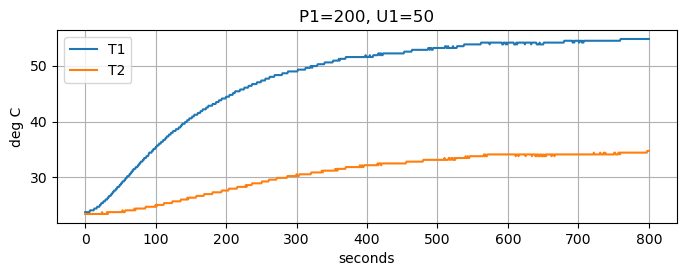

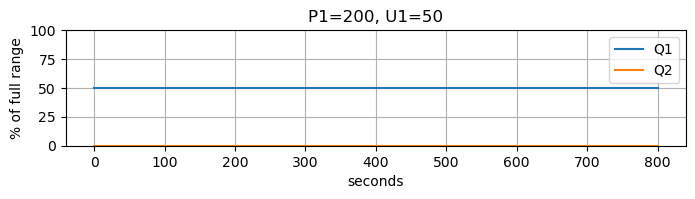

In [8]:
import matplotlib.pyplot as plt

data.plot(y=["T1", "T2"], 
          title=f"{P1=}, {U1=}",
          xlabel="seconds", 
          ylabel="deg C", 
          grid=True, 
          figsize=(8, 2.5)
         )

data.plot(y=["Q1", "Q2"],
          title=f"{P1=}, {U1=}",
          xlabel="seconds", 
          ylabel="% of full range", 
          grid=True, 
          figsize=(8, 1.5),
          ylim=(0, 100)
         )

plt.show()

Imagine you printed the plot above on paper. Using the plot, estimate the gain $K$ and and time constant $\tau$ from the plot. **Hint**: Look at your lecture notes. How did we do this for similar in-class example for linear first order systems?

Please typeset your answer and supporting calculations. You can either use Python as a simple calculator or use a scientific calculator. The calculation is not that hard. Do not overthink it.

--- BEGIN SOLUTION

**Gain**:

The TCLab starts around 24 degC and ends at 58 deg C (approximately) with 50\% power applied.

\begin{equation*}
K = \frac{\text{response}}{\text{input}} = \frac{58 \text{C} - 24 \text{C}}{50\%} = 0.68 \frac{\text{C}}{\%}
\end{equation*}

**Time Constant**:

The TCLab changes temperature by 34 degC. After 1 time constant, the system will achieve 63.2\% of the response. 34 times 63.2\% equals 21.5 degC.

How long does it take to reach 34 plus 21.5 equals 45 degC? About 210s. Thus,

\begin{equation*}
\tau = 210 \text{s}
\end{equation*}

--- END SOLUTION

### Analytical Solution for a Step Test

The goal of this assignment is to fit a first-order model to the step test. We use will be use the analytical solution for a first-order model subject to a step change in the input. Then, by trail-and-error, we will find a set of model parameters that provide a good fit to the experimental data. Finally, you will perform this fitting via nonlinear regression.

We start with a first-order model written in gain/time-constant form

\begin{equation*}
\tau\frac{dx}{dt} = -x + K \bar{u}
\end{equation*}

where $x = T_1 - T_{amb}$ and the $\bar{u}$ is a constant value for the input $u_1(t)$. The analytical solution consists of two parts

\begin{equation*}
x(t) = \underbrace{x_0e^{-t/\tau}}_{\text{initial condition }x_0} + \underbrace{(1 - e^{-t/\tau}) K \bar{u}}_{\text{input }\bar{u}}
\end{equation*}

The solution depends on three parameters:

* $x_0$: initial condition
* $K$: steady-state gain
* $\tau$: time constant

The initial condition $x_0 = 0$ if the step test starts at steady-state. In that case there are two parameters to fit, $K$ and $\tau$. The following cell demonstrates the calculation and plotting of the analytical solution.

### Graphically Determine the Gain and Time Constant

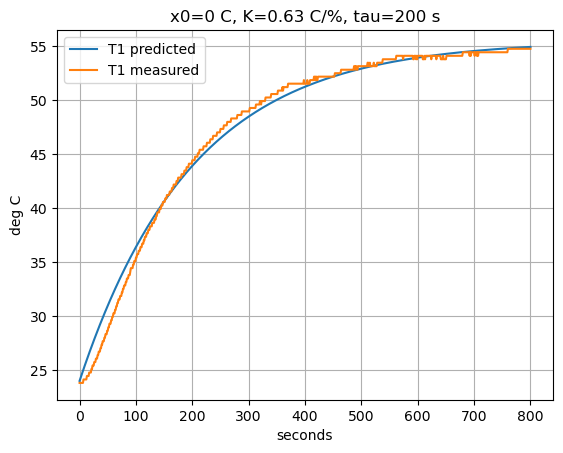

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# replace these with your calculation above
# then adjust until the plot visually matches the data
T_amb = 23
x0 = 0
K = 0.7
tau = 200 # seconds

### BEGIN SOLUTION
if True:
    T_amb = 24
    x0 = 0
    K = 0.63
    tau = 200
### END SOLUTION

# known input
U1 = 50

# compute analytical solution
t = data.index
x = x0*np.exp(-t/tau) + (1 - np.exp(-t/tau))*K*U1

# plotting solution for T1
T1 = x + T_amb
plt.plot(t, T1, t, data["T1"])
plt.legend(["T1 predicted", "T1 measured"])

# dress up the plot
plt.title(f"{x0=} C, {K=} C/%, {tau=} s")
plt.xlabel("seconds")
plt.ylabel("deg C")
plt.grid(True)


Remember to submit Exercise 0 via Gradescope.

## Exercise 1. Step Tests and Data Collection

We will now perform a step test to collect data you analyzed in Exercise 0, but this time using your own TCLab.

### Step 1. Verify operation.

Execute the following cell to verify that you have a working connection to the temperature control lab hardware. This will test for installation of TCLab.py, connection to the Arduino device, and working firmware within the Arduino.

In [16]:
from tclab import TCLab, clock, Historian, Plotter, setup

run_tclab = False

"""
In the labs, we will us "run_tclab" to control whether the TCLab is used.
After you finish the lab experiment, set run_tclab = False.
This way, you can run all the cells without losing your TCLab output.
"""

if run_tclab:
    TCLab = setup(connected=True)

    lab = TCLab()
    print("TCLab Temperatures:", lab.T1, lab.T2)
    lab.close()

### Step 2.  Check for steady state

As discussed in class, for step testing the device must be initially at steady state. Run the following code to verify the heaters are off and that the temperatures are at a steady ambient temperature.

In [19]:
if run_tclab:
    # experimental parameters
    tfinal = 30

    # perform experiment
    with TCLab() as lab:
        lab.U1 = 0
        lab.U2 = 0
        h = Historian(lab.sources) 
        p = Plotter(h, tfinal)
        for t in clock(tfinal):
            p.update(t)

### Step 3. Step Test

The step test consists of turning one heater one at 50% power and recording temperature data for at least 1200 seconds. Copy the code from Step 2 into the following cell. Then modify as needed to accomplish the step test with P1 at 200 and using 50% of maximum power.

In [21]:
if run_tclab:
    ### BEGIN SOLUTION

    # experimental parameters
    tfinal = 1200
    # perform experiment
    with TCLab() as lab:
        lab.P1 = 200
        lab.U1 = 50
        lab.U2 = 0
        h = Historian(lab.sources)
        p = Plotter(h, tfinal)
        for t in clock(tfinal):
            p.update(t)

    ### END SOLUTION

### Step 4. Save data to a .csv file

Run the following cell to verify and save your data to a '.csv' file. Be sure you can find and locate the data on your laptop before ending your session. You will need access to this data for subsequent exercises.

In [23]:
import matplotlib.pyplot as plt
import os.path

# Change the filename here
data_file = 'lab1-step-test.csv'

if run_tclab:

    t, T1, T2, Q1, Q2 = h.fields

    plt.plot(t, T1, t, T2, t, Q1, t, Q2)
    plt.legend(['T1','T2','Q1','Q2'])
    plt.xlabel('Time / seconds')
    plt.grid()



    # Set to True to overwrite the file. Default is False
    # to safeguard against accidentally rerunning this cell.
    overwrite_file = False

    if not overwrite_file and os.path.isfile('./'+data_file):
        raise FileExistsError(data_file + ' already exisits. Either choose a new filename or set overwrite_file = True.')
    elif run_tclab:
        h.to_csv(data_file)
        print("Successfully saved data to "+data_file)
    else:
        print("Data not saved. Set run_tclab = True to save the data.")

## Exercise 2. Determine First-Order Linear Model From Inspection

Do the following:
* Read the data you saved from your step test.
* Plot the results.
* Inspecting the plot for $T_1$, estimate the
    * gain
    * time constant
    * ambient temperature


,T1,T2,Q1,Q2
Time,,,,
0.00,20.254,19.932,50.0,0.0
1.01,20.254,19.932,50.0,0.0
2.01,20.254,19.932,50.0,0.0
3.01,20.254,19.932,50.0,0.0
4.01,20.254,19.932,50.0,0.0
...,...,...,...,...
1196.01,52.480,30.147,50.0,0.0
1197.01,52.480,30.212,50.0,0.0
1198.01,52.480,30.212,50.0,0.0


,T1,T2,Q1,Q2
Time,,,,
260.01,44.069,26.022,50.0,0.0
261.01,44.102,26.055,50.0,0.0
262.01,44.102,26.055,50.0,0.0
263.01,44.102,26.055,50.0,0.0
264.01,44.102,26.055,50.0,0.0
265.01,44.102,26.055,50.0,0.0
266.01,44.102,26.055,50.0,0.0
267.01,44.102,26.055,50.0,0.0
268.01,44.102,26.055,50.0,0.0


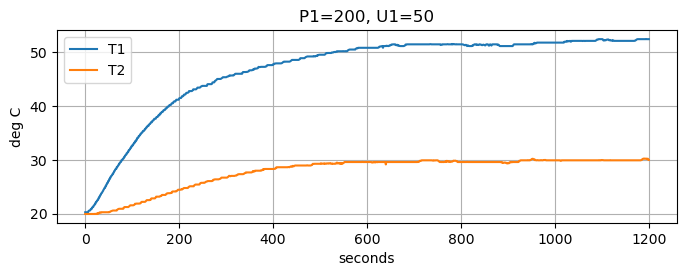

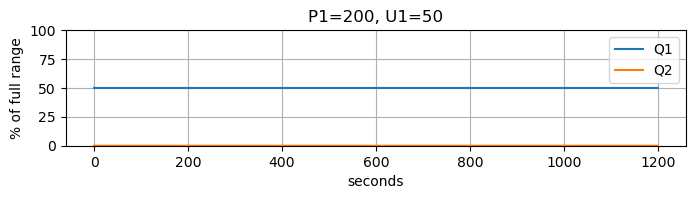

In [25]:
### BEGIN SOLUTION
import pandas as pd

# parameters
P1 = 200
U1 = 50

# get data
data = pd.read_csv(data_file, index_col = "Time")

#display step test data
display(data)

#plot data
data.plot(y=["T1", "T2"], 
          title=f"{P1=}, {U1=}",
          xlabel="seconds", 
          ylabel="deg C", 
          grid=True, 
          figsize=(8, 2.5)
         )

data.plot(y=["Q1", "Q2"],
          title=f"{P1=}, {U1=}",
          xlabel="seconds", 
          ylabel="% of full range", 
          grid=True, 
          figsize=(8, 1.5),
          ylim=(0, 100)
         )

around44 = data[data['T1'].between(43.8,44.2)]
display(around44)

### END SOLUTION

Write your estimates below in this markdown cell.

--- BEGIN SOLUTION

Gain - if the system is at steady state then: 

\begin{equation*}
0 = a \bar{x} + b \bar{u}
\end{equation*}

thus

\begin{equation*}
\bar{x}=-\frac{b}{a}\bar{u}
\end{equation*}

where the gain is 

\begin{equation*}
K=-\frac{b}{a}
\end{equation*}

in this case, the steady state temperature is ~55.74&deg;C and the ambient is 23&deg;C so $\bar{x} = 32.74C$

and $\bar{u}=50$ % corresponding to the heater output

thus $K=.6548$ &deg;C/%

Time constant - time it takes to get to 63.2% of the way to the final steady state value: 

\begin{equation*}
T(\tau) = .623*(55.74-23) + 23 = 43.98 C
\end{equation*}

This temp. is between 176s and 177s, thus $\tau$ = 176.5 s

Ambient temperature - The steady state temperature: 23&deg;C

--- END SOLUTION

## Exercise 3. Fit First-Order Linear Model with Numerical Simulations and Trail-and-Error

Fill in the function below to plot an analytical solution for the step response of a first-order model in gain/time constant form. Use your estimates of gain, time constant, initial condition, and the input. On the same plot, overlay a plot of the experimental data. Adjust parameter values until you get the a good fit of the model to the experimental data.

Note that you may need to also adjust values of the ambient temperature and initial condition to fit the model. 

Report the following:
* gain
* time constant
* ambient temperature
* initial condition

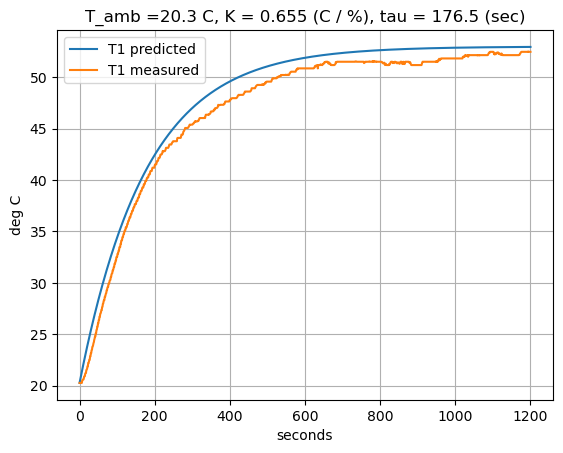

In [28]:
# First, create a function to compute the predicted values

import numpy as np
import matplotlib.pyplot as plt

def predict_first_order(data, K, tau, x0 = 0, U1=50, plot=False):
    '''
    Predict the temperature of a first order system.

    Arguments:
        t: time (seconds)
        x0: initial temperature (deg C)
        K: steady state gain (deg C/% U1)
        tau: time constant (seconds)
        U1: input as a percentage
        T_amb: ambient temperature (deg C)
        data: dataframe with columns T1, T2, Q1, Q2
        plot: True to plot the results
    
    Returns:
        T1_pred: predicted temperature (deg C)
    
    '''

    # Extract the time index and ambient temperature from
    # the Pandas dataframe
    t = data.index
    T_amb = data["T1"].iloc[0]

    ### BEGIN SOLUTION
    t = data.index
    T1_pred = x0*np.exp(-t/tau) + (1 - np.exp(-t/tau))*K*U1 + T_amb

    if plot:
        # Create the plot
        plt.plot(t, T1_pred, t, data["T1"])
        plt.legend(["T1 predicted", "T1 measured"])

        # Add title, labels, and grid
        plt.title("T_amb =" + str(round(T_amb,1)) + " C, K = " + str(round(K, 3)) + " (C / %), tau = " + str(round(tau,1)) + " (sec)")
        plt.xlabel("seconds")
        plt.ylabel("deg C")
        plt.grid(True)

    return T1_pred

    ### END SOLUTION


# Next, set an initial point
### BEGIN SOLUTION

# initial parameter values
T_amb = 23 # °C
x0 = 0 # °C
K = 0.6548 # °C/% U1
tau = 176.5 # sec
U1 = 50 # %

### END SOLUTION

# Test the function using the initial guess

### BEGIN SOLUTION
T1 = predict_first_order(data, K, tau, plot=True)
### END SOLUTION



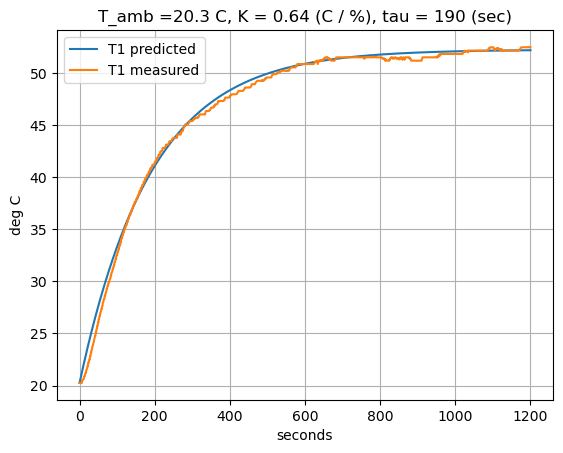

In [29]:
# Adjust the parameters by hand to improve the fit
# Because everyone has their own TCLab and dataset, everyone
# should have a slightly different answer.

### BEGIN SOLUTION

T1 = predict_first_order(data, 
                    K=0.64, 
                    tau=190, 
                    plot=True)

### END SOLUTION

## Exercise 4. Fit First-Order Model via Nonlinear Regression

Next, you will fit the first-order linear model using nonlinear regression. Hint: You practiced using `least_squares` in Homework 1.

In [32]:
from scipy.optimize import least_squares

def first_order_model(p):
    '''
    Predict the temperature of a first order system.

    Arguments:
        p: list of parameters [tau, K]
    
    Returns:
        T1_pred: predicted temperature (deg C)
    
    '''

    # Unpack the parameters
    K, tau = p

    return predict_first_order(data, K=K, tau=tau, plot=False)


### BEGIN SOLUTION

# Define inline function to calculate residuals from experimental data
residuals = lambda p : first_order_model(p) - data["T1"]

# Set initial point
p0 = [0.8, 170]

# Set bounds (non-negative)
bnds = ([0.0, 0.0], [np.inf, np.inf])

# Perform least squares nonlinear regression
nl_results = least_squares(residuals, p0, bounds=bnds, method='trf',verbose=2, loss="arctan")
p_fit = nl_results.x

K_fit, tau_fit = p_fit

### END SOLUTION

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.2700e+02                                    9.55e+01    
       1              6         9.1668e+02      1.03e+01       5.94e-01       7.12e+01    
       2              7         9.0118e+02      1.55e+01       1.66e-01       1.24e+02    
       3              8         8.8650e+02      1.47e+01       4.18e+00       2.84e+02    
       4              9         8.0859e+02      7.79e+01       8.65e+00       2.32e+03    
       5             12         3.9296e+02      4.16e+02       8.42e-02       1.51e+04    
       6             14         3.0487e+02      8.81e+01       3.35e-02       1.99e+04    
       7             15         1.4090e+02      1.64e+02       1.04e-02       9.02e+03    
       8             16         1.1931e+02      2.16e+01       2.08e-02       3.74e+02    
       9             17         1.1901e+02      3.08e-01       4.15e-02       5.33e+00    

K = 0.637 °C/% U1
tau = 192.4 seconds


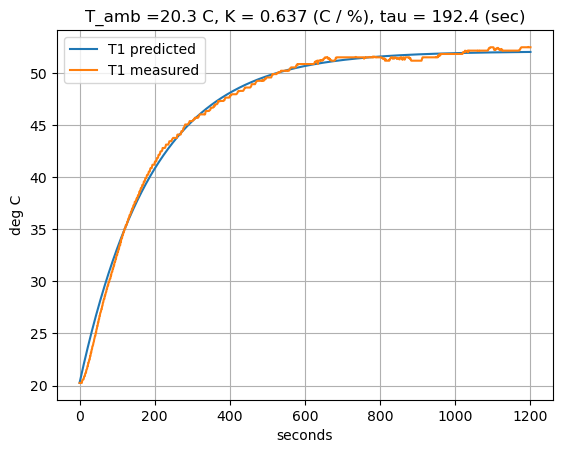

In [33]:
# Print the result here with units and a reasonable number of significant digits.

### BEGIN SOLUTION

print("K =", round(K_fit,3), "°C/% U1")
print("tau =", round(tau_fit,1), "seconds")

### END SOLUTION

# Plot the results

### BEGIN SOLUTION

T1 = predict_first_order(data, K=K_fit, tau=tau_fit, plot=True)

### END SOLUTION

How do these results compare to your "by hand" trial-and-error fitting? Write 1 to 3 sentences.

--- BEGIN SOLUTION

The nonlinear regression determined the (numeric) answer to more digits. With "by hand", it was hard to judge if the changes improved the quality of fit visually.

--- END SOLUTION

## Exercise 5. State-Space Model

A first-order model in gain/time constant form is given by

\begin{equation*}
\tau\frac{dx}{dt} = - x + K u
\end{equation*}

Where $x$ is the state variable. Again letting $x = T_1 - T_{amb}$ and $u = u_1$  Comparing this model of a first order system to the model given up for the heater/sensor assembly.

Do the following:
* Derive expressions for the parameters $\tau$ and $K$ in terms of $C_p$, $U_a$, $\alpha$, and $P_1$. 
* Assume $\alpha = 0.16$ milliwatts per unit of $P1$ per percent. Solve for estimates of $C_p$ and $U_a$. 

Remember: Everyone has their own TCLab device, which means everyone has their own unique data. As such, everyone should have slightly different calculated values for $C_p$ and $U_a$.

--- BEGIN SOLUTION

The energy ballance is:

\begin{align*}
C_p\frac{dT_1}{dt} & = U_a(T_{amb} - T_1) + \alpha P_1u_1 \\
\end{align*}


rearranged

\begin{align*}
\frac{dT_1}{dt} & = \frac{U_a}{C_p}(T_{amb} - T_1) + \frac{\alpha P_1}{C_p}u_1 \\
\end{align*}

then take 

\begin{align*} 
x & = T_1 - T_{amb}
\end{align*}


to get 

\begin{align*}
\frac{dx}{dt} & = \frac{-U_a}{C_p}x + \frac{\alpha P_1}{C_p}u_1
\end{align*}  

the gain/time-constant form is 

\begin{align*} \tau\frac{dx}{dt} = -x + K \bar{u} \end{align*}


which rearranges to 

\begin{align*}
\frac{dx}{dt} = -\frac{1}{\tau} x + \frac{K}{\tau} \bar{u} \end{align*}

so 

\begin{align*} \tau & = \frac{C_p}{U_a} \end{align*}

and 

\begin{align*} K & = \frac{\alpha P_1}{C_p} \tau = \frac{\alpha P_1}{C_p} \frac{C_p}{U_a} = \frac{\alpha P_1}{U_a}\end{align*}

plugging in for $K$ gives

\begin{equation*} K = \frac{\alpha P_1}{U_a} = 0.6759 \frac{\text{°C}}{\%} = \frac{0.16 \frac{\text{mW}}{\% \text{units} P_1}}{U_a} 200 \text{ units } P_1 \end{equation*}


\begin{equation*} U_a = 47.34 \frac{\text{mW}}{\text{°C}}\end{equation*}


and plugging in for $\tau$ 

\begin{equation*} \tau = \frac{C_p}{U_a} = 180.7 s = \frac{C_p}{47.34 \text{ mW } \text{°C}^{-1}}\end{equation*}

\begin{equation*} C_p  = 8554\frac{\text{mJ}}{\text{°C}} = 8.55 \frac{\text{J}}{\text{°C}} \end{equation*}

--- END SOLUTION

## Exercise 6. Discussion

Below discuss issues you would face in writing a Python function to automatically fit the model of the heater/sensor assembly to step test data. For each question, please write a few sentences.

**How can you measure the quality of fit?**

--- BEGIN SOLUTION

Quality of fit can be judged by standard absolute error and/or sum of square error. One interesting aspect is that, in the graphs above, the error is clearly dependent on the time of the experiment. This may indicate problems with the model, as the error should be random across the data set, not systematic. At the start of the experiment this seems attributable to some time delay as the heater conducts heat to the sensor. The model could be improved by accounting for the heat transfer between the heater and sensor.

--- END SOLUTION

**How should one handle bad measurements?**

--- BEGIN SOLUTION

In this case there is some noise in the measurments. Minimizing absolute error rather than the square error will keep large noisy measurements from being disproportionately amplified

--- END SOLUTION

**What parameters should be fit?**

--- BEGIN SOLUTION

Tau and K (or $C_p$ and $U_a$). The ambient temperature and starting temperature are known because the system should have been started at a steady state which was the ambient temperature. Alpha was given and $P_1$ and $u_1$ are set at the outset of the experiment.

--- END SOLUTION

**How can you estimate uncertainty in the estimates of $C_p$ and $U_a$?**

--- BEGIN SOLUTION

You can estimate the uncertainty in $C_p$ and $U_a$ through running several experiments and examining the range of parameter values.

Or we can add more rigor to the regression analysis by calculating the covariance matrix of the fitted parameters.

--- END SOLUTION

**Is it possible to estimate $U_a$ from a steady state experiment?**

--- BEGIN SOLUTION

Yes - If $\frac{dT_1}{dt}$ is set to 0 then $T_1$ is the steady state temperature and $\alpha$, $P_1$ and $U_1$ are all known constants so you can solve for $U_a$

--- END SOLUTION

**Is is possible to estimate $C_p$ from a steady state experiment?**

--- BEGIN SOLUTION

No - In a similar manner to above, if d$T_1$/dt in Eq.1 above is set to 0 then $C_p$ is a a constant multiplier of a 0 term that can't be found

--- END SOLUTION


## Declarations

**Collaboration**: If you worked with any classmates, please give their names here. Describe the nature of the collaboration.

**Generative AI**: If you used any Generative AI tools, please elaborate here.

**Reminder:** The written discussions responses must be in your own words. Many of these questions ask about your specific results or are open-ended questions with many reasonable answers. Thus we expect unique responses, analyses, and ideas.

We may use writing analysis software to check for overly similar written responses. You are responsible for reviewing the colaboration policy outlined in the class syllabus to avoid violations of the honor code.